In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import warnings
import joblib
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline 
from datasist.structdata import detect_outliers
from imblearn.under_sampling import RandomUnderSampler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB,GaussianNB
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import cross_validate,GridSearchCV
from sklearn.metrics import f1_score,recall_score,precision_score,plot_confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler,StandardScaler,RobustScaler
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import PolynomialFeatures
warnings.filterwarnings('ignore')

In [2]:
df=pd.read_csv('Strocke')

In [3]:
df

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke,Glucose_level
0,Male,67,0,1,Yes,Private,Urban,228,36.6,formerly smoked,1,diabetes
1,Female,61,0,0,Yes,Self-employed,Rural,202,NaN,never smoked,1,diabetes
2,Male,80,0,1,Yes,Private,Rural,105,32.5,never smoked,1,normal
3,Female,49,0,0,Yes,Private,Urban,171,34.4,smokes,1,prediabetes
4,Female,79,1,0,Yes,Self-employed,Rural,174,24.0,never smoked,1,prediabetes
...,...,...,...,...,...,...,...,...,...,...,...,...
4982,Female,80,1,0,Yes,Private,Urban,83,NaN,never smoked,0,low
4983,Female,81,0,0,Yes,Self-employed,Urban,125,40.0,never smoked,0,normal
4984,Female,35,0,0,Yes,Self-employed,Rural,82,30.6,never smoked,0,low
4985,Male,51,0,0,Yes,Private,Rural,166,25.6,formerly smoked,0,prediabetes


In [4]:
encode=['gender','ever_married','work_type','Residence_type','smoking_status','Glucose_level']

In [5]:
encoder = ColumnTransformer(transformers=[("enc",OneHotEncoder(sparse=False, drop="first"),encode), 
                            ('imputer',SimpleImputer(strategy='median'),['bmi'])], remainder="passthrough")
encoder

ColumnTransformer(remainder='passthrough',
                  transformers=[('enc',
                                 OneHotEncoder(drop='first', sparse=False),
                                 ['gender', 'ever_married', 'work_type',
                                  'Residence_type', 'smoking_status',
                                  'Glucose_level']),
                                ('imputer', SimpleImputer(strategy='median'),
                                 ['bmi'])])

In [6]:
x= df.drop(['stroke'] , axis = 1 )
y=df['stroke']

In [7]:
models=[]
models.append(('LR',LogisticRegression()))
models.append(('Knn',KNeighborsClassifier()))
models.append(('MUN',MultinomialNB()))
models.append(('Guss',GaussianNB()))
models.append(('XG',XGBClassifier()))
models.append(('SVM',SVC()))
models.append(('DECT',DecisionTreeClassifier()))
models.append(('RF',RandomForestClassifier(random_state=42)))
models.append(('Voting',VotingClassifier(estimators=[('RF',RandomForestClassifier()),('LR',LogisticRegression())])))

In [8]:
Over =SMOTE(random_state=7)
Under = RandomUnderSampler()
for model in models:
    steps = []
    steps.append(('encoder',encoder))
    steps.append(('scaler',MinMaxScaler()))
    steps.append(("Over", Over))
    steps.append(("Under", Under))
    steps.append(model)
    pipline = Pipeline(steps=steps)
    scores = cross_validate(pipline,x,y, cv = 5,scoring=['accuracy','precision','f1','recall'],return_train_score=True,error_score='raise')
    print('_'*40)
    print(model[0])
    print("train_recall", scores["train_recall"].mean())
    print("test_recall" , scores["test_recall"].mean())
    print('*'*40)
    print("train_f1", scores["train_f1"].mean())
    print("test_f1" , scores["test_f1"].mean())
    print('*'*40)
    print("train_precision", scores["train_precision"].mean())
    print("test_precision" , scores["test_precision"].mean())
    print('*'*40)
    print("train_accuracy", scores["train_accuracy"].mean())
    print("test_accuracy" , scores["test_accuracy"].mean())

________________________________________
LR
train_recall 0.8125069793411501
test_recall 0.7903673469387755
****************************************
train_f1 0.2383728085059434
test_f1 0.2331981258182088
****************************************
train_precision 0.1396761937514505
test_precision 0.13689285896080117
****************************************
train_accuracy 0.7417789020055781
test_accuracy 0.7407251815566941
________________________________________
Knn
train_recall 0.9848992436932136
test_recall 0.30261224489795924
****************************************
train_f1 0.4798517179164894
test_f1 0.14545564443456319
****************************************
train_precision 0.3172985698053796
test_precision 0.095863736738328
****************************************
train_accuracy 0.8937235166130417
test_accuracy 0.8229431782320911
________________________________________
MUN
train_recall 0.7046342825237298
test_recall 0.6929795918367346
****************************************
train_

In [9]:
steps = list()
steps.append(("Encoder",encoder))
steps.append(("Scaler" , MinMaxScaler()))
steps.append(("Over", Over))
steps.append(("Under", Under))
steps.append(("Model" , RandomForestClassifier()))
pipeline = Pipeline(steps=steps)

In [10]:
params = [
    
    { "Model__criterion" : ["gini", "entropy"],"Model__max_depth" : range(5 , 10 ),'Model__min_samples_split':range(2,5),
     'Model__min_samples_leaf':range(1,5)}
]

In [11]:
grid = GridSearchCV(pipeline , params , cv = 5 , scoring="accuracy" , return_train_score=True)

In [12]:
grid.fit(x,y)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('Encoder',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('enc',
                                                                         OneHotEncoder(drop='first',
                                                                                       sparse=False),
                                                                         ['gender',
                                                                          'ever_married',
                                                                          'work_type',
                                                                          'Residence_type',
                                                                          'smoking_status',
                                                                          'Glucose_level']),
                                                                        ('imputer',
                                                                         SimpleImputer(strategy='median'),
                                                                         ['bmi'])])),
                                       ('Scaler', MinMaxScaler()),
                                       ('Over', SMOTE(random_state=7)),
                                       ('Under', RandomUnderSampler()),
                                       ('Model', RandomForestClassifier())]),
             param_grid=[{'Model__criterion': ['gini', 'entropy'],
                          'Model__max_depth': range(5, 10),
                          'Model__min_samples_leaf': range(1, 5),
                          'Model__min_samples_split': range(2, 5)}],
             return_train_score=True, scoring='accuracy')

In [13]:
grid.best_params_

{'Model__criterion': 'gini',
 'Model__max_depth': 9,
 'Model__min_samples_leaf': 1,
 'Model__min_samples_split': 3}

In [14]:
grid.cv_results_["mean_train_score"].max()

0.8781827720466872

In [15]:
grid.cv_results_["mean_test_score"].max()

0.8315656388001681

In [42]:
steps = list()
steps.append(("Encoder",encoder))
steps.append(("Scaler" , MinMaxScaler()))
steps.append(("Over", Over))
steps.append(("Under", Under))
steps.append(("Model" , RandomForestClassifier(criterion='gini',max_depth=9,min_samples_leaf=1,min_samples_split=3)))
pipeline = Pipeline(steps=steps)

In [43]:
score=cross_validate(pipeline,x,y,cv=5,scoring='accuracy',return_train_score=True)

In [44]:
score['train_score'].mean()

0.877179888804488

In [45]:
score['test_score'].mean()

0.8285568127227373

In [46]:
#temp_x=pd.DataFrame(pipeline[0].fit_transform(x))

In [47]:
#Forward = SequentialFeatureSelector(estimator=pipeline[1:] , n_features_to_select="auto" , tol = None , direction="forward")

In [48]:
#Forward.fit(temp_x,y)

In [49]:
#new_x_f = pd.DataFrame(Forward.transform(temp_x) , columns= Forward.get_feature_names_out())

In [50]:
#new_x_f

In [74]:
x_train, x_test, y_train, y_test = train_test_split(x, y,test_size = 0.15, random_state =7, stratify = y)
steps = list()
steps.append(("Encoder",encoder))
steps.append(("Scaler" , MinMaxScaler()))
steps.append(("Over", Over))
steps.append(("Under", Under))
steps.append(("RF" , RandomForestClassifier()))
pipeline = Pipeline(steps)

In [75]:
pipeline.fit(x_train, y_train)

Pipeline(steps=[('Encoder',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('enc',
                                                  OneHotEncoder(drop='first',
                                                                sparse=False),
                                                  ['gender', 'ever_married',
                                                   'work_type',
                                                   'Residence_type',
                                                   'smoking_status',
                                                   'Glucose_level']),
                                                 ('imputer',
                                                  SimpleImputer(strategy='median'),
                                                  ['bmi'])])),
                ('Scaler', MinMaxScaler()), ('Over', SMOTE(random_state=7)),
                ('Under', RandomUnderSampler()),
                ('RF', RandomForestClassifier())])

In [76]:
recall_score(pipeline.predict(x_train), y_train)

1.0

In [77]:
recall_score(pipeline.predict(x_test), y_test)

0.13793103448275862

In [78]:
f1_score(pipeline.predict(x_train), y_train)

1.0

In [79]:
f1_score(pipeline.predict(x_test), y_test)

0.12121212121212122

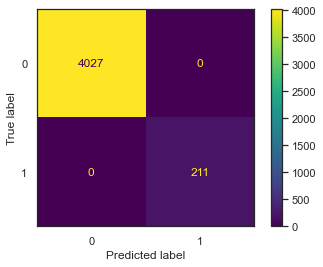

In [80]:
sns.set_theme(style='white')
plot_confusion_matrix(pipeline , x_train , y_train)

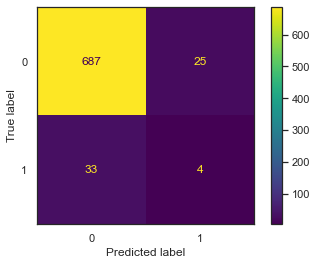

In [81]:
sns.set_theme(style='white')
plot_confusion_matrix(pipeline , x_test , y_test)

In [82]:
test_data=pd.DataFrame(columns=x.columns)

In [83]:
test_data

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,Glucose_level


In [84]:
test_data.at[0,'gender']='Male'
test_data.at[0,'age']=67
test_data.at[0,'hypertension']=0
test_data.at[0,'heart_disease']=1
test_data.at[0,'ever_married']='Yes'
test_data.at[0,'work_type']='Private'
test_data.at[0,'Residence_type']='Urban'
test_data.at[0,'avg_glucose_level']=228
test_data.at[0,'bmi']=36.6
test_data.at[0,'smoking_status']= 'formerly smoked'
test_data.at[0,'Glucose_level']='diabetes'

In [71]:
model=pipeline.fit(x,y)

In [72]:
test_data

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,Glucose_level
0,Male,67,0,1,Yes,Private,Urban,228,36.6,formerly smoked,diabetes


In [73]:
model.predict(test_data)

array([1], dtype=int64)

In [39]:
final_pipeline=grid.best_estimator_

In [40]:
final_pipeline

Pipeline(steps=[('Encoder',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('enc',
                                                  OneHotEncoder(drop='first',
                                                                sparse=False),
                                                  ['gender', 'ever_married',
                                                   'work_type',
                                                   'Residence_type',
                                                   'smoking_status',
                                                   'Glucose_level']),
                                                 ('imputer',
                                                  SimpleImputer(strategy='median'),
                                                  ['bmi'])])),
                ('Scaler', MinMaxScaler()), ('Over', SMOTE(random_state=7)),
                ('Under', RandomUnderSampler()),
                ('Model',
                 RandomForestClassifier(max_depth=9, min_samples_split=3))])

In [41]:
joblib.dump(final_pipeline , "Model.h5")
joblib.dump(x.columns,"input.h5")

['input.h5']